# Designing an optimal Coffee extraction with Python

Necessary libs:

In [1]:
import scipy.integrate as integrate
from scipy.optimize import differential_evolution
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Solving the ODE

Reading data from experiments:

In [2]:
exp_data = pd.read_csv('../data/coffee_conc_norm.csv')

exp_data

,t,c_h
0,28.864060,1.430038
1,41.433892,1.565861
2,73.556797,1.698785
3,125.232775,1.786578
4,294.692737,1.799666
5,421.787709,1.800433


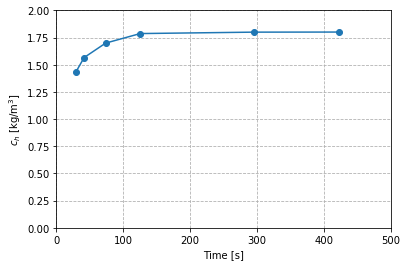

In [3]:
plt.plot(exp_data.t, exp_data.c_h, 'o-')
plt.xlabel('Time [s]')
plt.ylabel(r'$c_h$ [kg/m$^3$]')
plt.grid(True, linestyle='--')
plt.xlim([0, 500])
plt.ylim([0, 2])
plt.show()

Model data:

* Physical parameters (measured):

In [4]:
phi_h = 0.8272
k_sv1 = 27.35e-6
k_sv2 = 322.49e-6
l_l = 282e-6
D_h = D_v = 2.2e-9
m = 30e-6
c_sat = 212.4
c_s = 1400.0
phi_v_inf = 0.6444
phi_cd = 0.143435
phi_s_s0 = 0.059
r_s = 1 / phi_s_s0
gamma_1 = 0.70

* Fitting parameters:

In [5]:
alpha = 0.1833
beta = 0.0447

* Non-dimensional parameters:

In [6]:
numerator = alpha * D_v * k_sv1 * m * phi_v_inf ** (1. / 3.) * c_s
denominator = 2 * beta * D_h * k_sv2 * l_l * phi_cd * c_sat * r_s
eps = numerator / denominator

eps

0.043320528410916714

In [7]:
numerator = 2 * beta * D_h * k_sv2 * l_l * phi_cd * phi_v_inf ** (2. / 3.) * (1 - phi_h) * c_sat * r_s
denominator = alpha * D_v * k_sv1 * m * phi_h * c_s
b_1 = numerator / denominator

b_1

3.1073845262218702

In [8]:
numerator = 2 * beta * D_h * k_sv2 * l_l * phi_cd * (1 - phi_h)
denominator = alpha * D_v * k_sv1 * m * phi_h * phi_v_inf ** (1. / 3.)
b_2 = numerator / denominator

b_2

1.8752751641107217

Scale factor:

In [9]:
c_h_factor = c_sat * phi_v_inf * (1 - phi_h) / phi_h

Initial conditions:

In [10]:
c_h0 = 0.
c_v0 = gamma_1
psi_s0 = 1

EDO's system right-hand-side (RHS):

In [11]:
def coffee(t, X, alpha, beta):
    #Variables
    c_h, c_v, psi_s = X
    
    # Time derivatives
    # c_h
    c_h_prime = - eps * b_2 * c_h * psi_s + psi_s - eps * eps * b_1 * c_h + eps * b_1 / b_2 * c_v
    # c_v
    c_v_prime = eps * eps * b_2 * c_h - eps * c_v
    # psi_s
    psi_s_prime = eps * b_2 * c_h * psi_s - psi_s
    
    return c_h_prime, c_v_prime, psi_s_prime

Time step parameters:

In [12]:
t0 = 0  # tempo inicial
tmax = 500. # tempo máximo

Solving with RADAU IIA method:

In [13]:
solution_RADAU = integrate.solve_ivp(
    lambda t, X: coffee(t, X, alpha, beta), 
    t_span=(t0, tmax), 
    y0=(c_h0, c_v0, psi_s0,), 
    method='Radau'
)

solution_RADAU

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 215
     njev: 2
      nlu: 42
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.34491794e-03, 1.47940973e-02, 1.49285891e-01,
       5.05792684e-01, 1.01677712e+00, 1.65596157e+00, 2.29514603e+00,
       3.06667404e+00, 3.83820206e+00, 4.60973007e+00, 5.38125808e+00,
       6.15278609e+00, 6.92431411e+00, 7.69584212e+00, 8.64742516e+00,
       9.59900820e+00, 1.08249184e+01, 1.23572446e+01, 1.44431095e+01,
       1.74205351e+01, 2.29808935e+01, 3.66637068e+01, 5.44331076e+01,
       7.22025084e+01, 9.61637159e+01, 1.26819729e+02, 1.69780913e+02,
       2.38671758e+02, 3.79236246e+02, 5.00000000e+02])
 t_events: None
        y: array([[ 0.00000000e+00,  1.41150932e-03,  1.54185238e-02,
         1.45310923e-01,  4.15843028e-01,  6.74066614e-01,
         8.69872151e-01,  9.87656299e-01,  1.07550289e+00,
         1.13271694e+00,  1.17444208e+00,  1.20804081e+00,
    

Gathering the solutions:

In [14]:
times, variables = solution_RADAU.t, solution_RADAU.y

Separating the solutions:

In [15]:
c_h, c_v, psi_s = variables

Plotting the solutions:

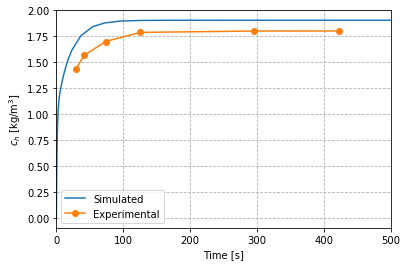

In [16]:
plt.plot(times, c_h, label='Simulated')
plt.plot(exp_data.t, exp_data.c_h, 'o-', label='Experimental')
plt.xlabel('Time [s]')
plt.ylabel(r'$c_h$ [kg/m$^3$]')
plt.grid(True, linestyle='--')
plt.xlim([0, 500])
# plt.ylim([0, 2.2])
plt.legend()
plt.savefig('calibration_model2.png')
plt.show()